<a href="https://colab.research.google.com/github/Yochiyan/Clock/blob/main/20240607_openCALM_catchphrase_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#はじめに

Google Driveのマイドライブ直下（下図参照）に配布したZIPファイルを設置してください．

**※ZIPを解凍したりフォルダの中へ入れたりしないでください，以降のコードが動作しません．**
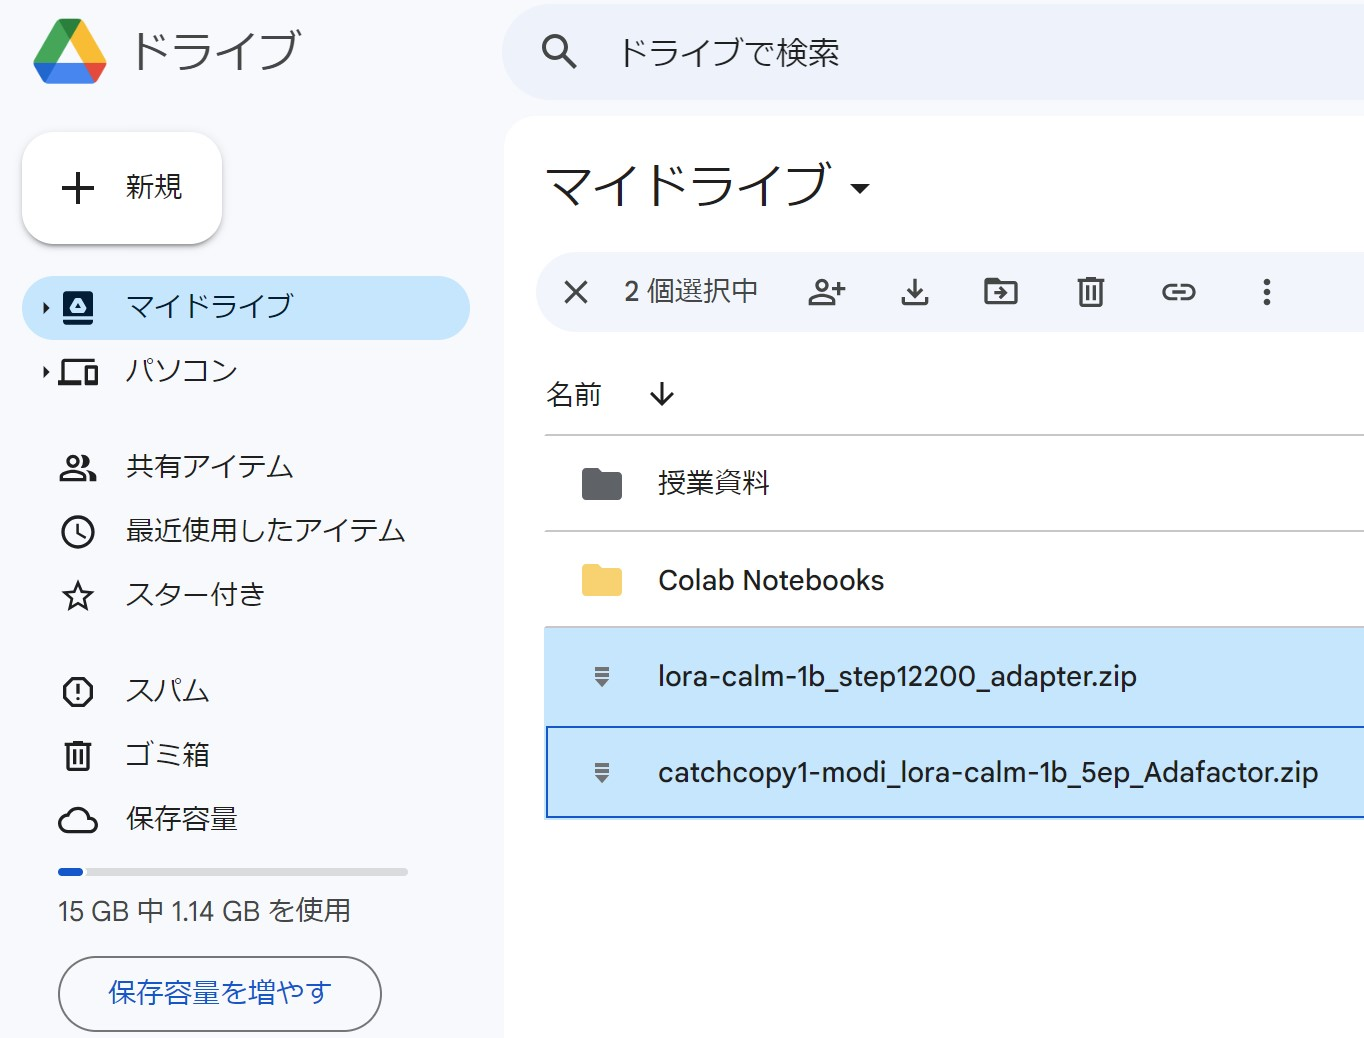


#自然言語処理モデル（OpenCALM）によるキャッチコピー生成

OpenCALMは，サイバーエージェント社が公開した，商用利用可能なオープンソースの日本語LLMです．基礎モデルであるため，下流タスクでファインチューニングを行って活用します．


なお，このモデルは，EleutherAIの研究者がオープンソースとして公開した[GPT-NeoX](https://github.com/EleutherAI/gpt-neox)を日本語で事前学習させたものです．
GPT-NeoXの中でもモデルサイズ最大級のGPT-NeoX-20bは，パラメータ数200億（20 billion）であり，GPT-3モデルに匹敵する性能を備えると言われています．

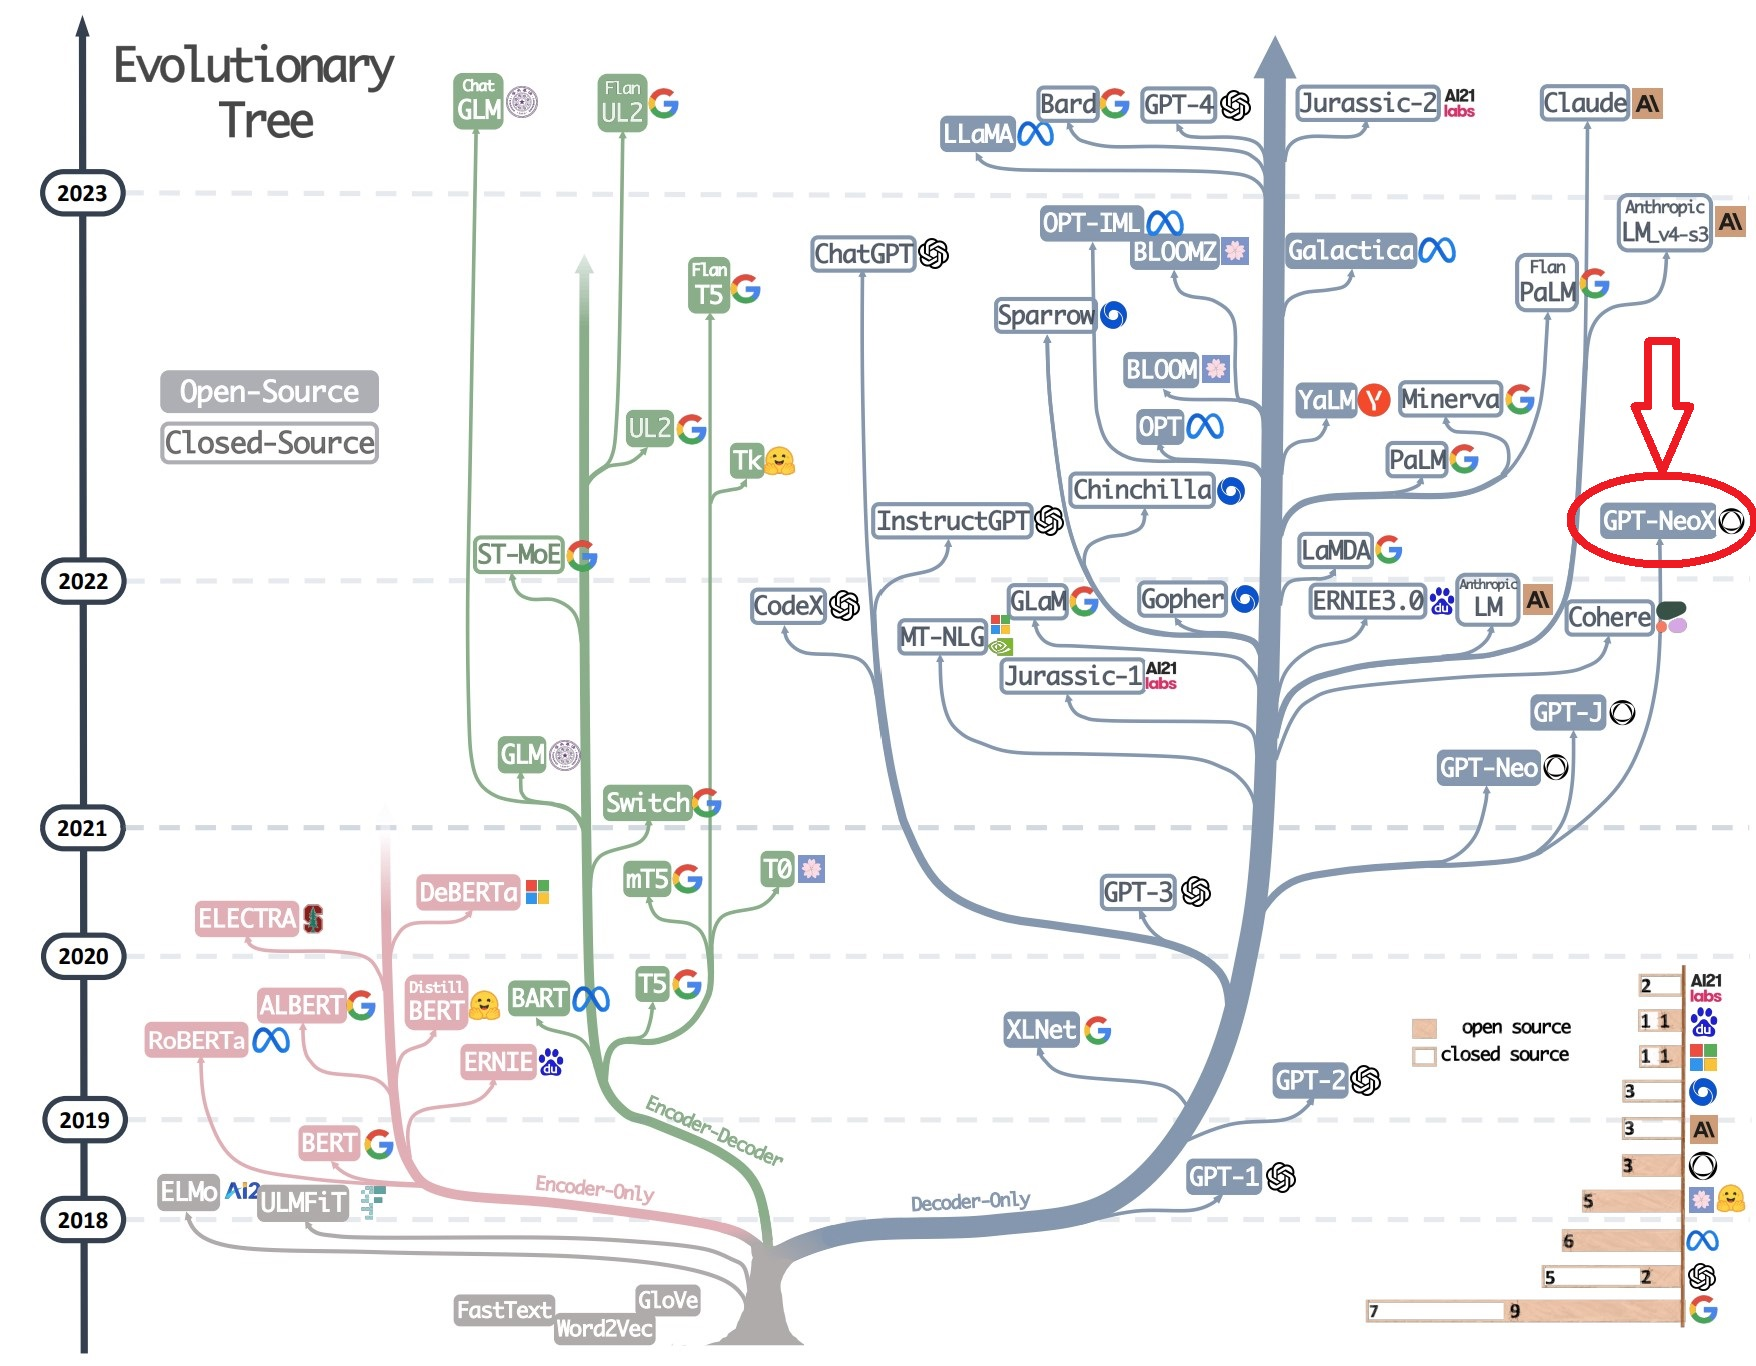

<small>
Harnessing the Power of LLMs in Practice: A Survey on ChatGPT and Beyond. (Nov. 8, 2023, 00:30 UTC). In arXiv:The Open Access Eprint Archive. Retrieved from https://arxiv.org/abs/2304.13712
</small>


OpenCALMも複数のモデルサイズが用意されています．本ハンズオン資料では，Google Colabの無償版で扱える最大サイズ：open-calm-1b（パラメータ数14億）のモデルを使用します．


---
［GPT-NeoX(GitHub)］https://github.com/EleutherAI/gpt-neox

［hugging face(1b)］ https://huggingface.co/cyberagent/open-calm-1b

［サイバーエージェント社］https://www.cyberagent.co.jp/news/detail/id=28817

## ライブラリ・データセット準備

In [ ]:
# NVIDIA GPU環境の有無を確認する
!nvidia-smi

# pyTorchライブラリのバージョンを確認する
# 2.3.0+cu121で動作確認済
import torch
print('pyTorch version:',torch.__version__)

Sun Jul 14 06:05:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
################################################################################
# このセルは，実行完了までに 2～3分 ほど時間が掛かります．
################################################################################

# 2024/06/05 時点 ライブラリバージョン衝突回避のためのアンインストール
!pip uninstall -q -y google-colab

# 外部ライブラリインストール
# peft==0.11.1 transformers==4.41.1 datasets==2.19.1で動作確認済
!pip install -q peft transformers datasets

import os # os：標準ライブラリ，OS依存の処理（環境変数やフォルダ作成など）を扱う
from IPython.display import display # Colabなどで一部のデータをprint()よりも綺麗に出力できる関数

# transformers : 外部ライブラリ，Huggingface社が公開しているtransformer派生モデルを実装するフレームワーク
import transformers
# peft : 外部ライブラリ，Huggingface-transformersと高度に統合されているParameter-Efficient Fine-Tuning (PEFT，パラメータ効率が高い微調整)用フレームワーク
import peft

# Huggingface社が公開しているデータセットを簡単に扱える外部ライブラリ
from datasets import load_dataset

os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

import warnings
warnings.simplefilter('ignore')

import random
import numpy as np
import torch

def torch_set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


# 擬似乱数seed固定
torch_set_seed(seed=321)

# 定数定義
MODEL_NAME = "cyberagent/open-calm-1b"
PEFT_NAME = "lora-calm-1b"
PEFT_NAME_CATCHPHRASE = "lora-calm-1b_catchphrase"
MAX_TOKEN_LEN = 1024


# トークナイザ定義
def tokenize(prompt, tokenizer):
    result = tokenizer(
        prompt+"<|endoftext|>",
        truncation=True,
        max_length=MAX_TOKEN_LEN,
        padding=False,
    )
    return {
        "input_ids": result["input_ids"],
        "attention_mask": result["attention_mask"],
    }


# トークナイザ準備
tokenizer =transformers.AutoTokenizer.from_pretrained(MODEL_NAME,
                                          se_auth_token=True,
                                          truncation=True,
                                          max_length=MAX_TOKEN_LEN)

# トークナイザの出力確認
print("\n トークナイザの出力確認")
display( tokenize("大学祭のキャッチコピーを出力してください。", tokenizer) )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]


 トークナイザの出力確認


{'input_ids': [885, 2459, 244, 30004, 1445, 7906, 2509, 247, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

## 生成時のプロンプトテンプレート準備

In [ ]:
# 生成時のプロンプトテンプレートの準備
def generate_prompt(data_point):
    if data_point["input"]:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{data_point["instruction"]}

### Input:
{data_point["input"]}

### Response:"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{data_point["instruction"]}

### Response:"""



# テキスト生成関数の定義
def generate(model, instruction, input=None, maxTokens=1024, temperature=1.0, top_p=1.0, top_k=50):


    # 推論
    prompt = generate_prompt({'instruction':instruction,'input':input})

    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True,
                          max_length = maxTokens,
                          ).input_ids.cuda()

    outputs = model.generate(
        input_ids = input_ids,
        max_new_tokens = maxTokens,# 整数型，生成するトークンの最大数（プロンプトのトークン数は無視）
        do_sample = True, # True/False サンプリング適用可否
        temperature = temperature, # 実数型（0＜temperature，小さいと確率が高い/厳密な回答，大きくすると創造的だが無関係な出力になりやすい）
        top_p = top_p, # 実数型（0 < top_p <= 1.0，小さくすると確率が高い単語に絞られる，小さくし過ぎると文章にならない）
        top_k = top_k, # 整数型（0より大きい整数，大きくし過ぎると無関係な単語も生成候補となる，小さくし過ぎると文章にならない）
        early_stopping = False, #　True/False，ビーム検索停止条件の制御用
        num_beams = 2, # 整数型，ビーム検索のビーム数（ 1 はビーム検索を行わない）
        num_beam_groups = 1, # 整数型，num_beamsの分割グループ数（ビーム検索時に異なるグループ間の多様性を保持する）※ num_beams 以下の値であること
        #typical_p = 1.0, # 実数型，局所的な典型性；既に生成された部分テキストを考慮に入れた次のターゲットトークンの予測条件確率と，ランダムなトークンの次の予測条件確率の期待値との類似度を測定する．
        # 1.0未満の場合，確率がtypical_p以上になる局所的に典型的なトークンの最小セットのみを生成のために保持する． ※ num_beams_groupと同時設定不可．
        epsilon_cutoff = 0.0, # 実数型，条件付き確率がepsilon_cutoffより大きいトークンのみがサンプリングされる．モデルサイズにより最適値が変わるが，3e-4 ～ 9e-4 あたりが推奨値とされる．
        diversity_penalty = 0.0, # 実数型，他のグループのビームと同じトークンを生成する場合にビームのスコアから差し引く値（0.0でペナルティ無し）．※ num_beam_groups設定時のみ有効．
        repetition_penalty = 1.0, # 実数型，繰り返し同じトークンを生成することに対するペナルティ（1.0でペナルティ無し）
        encoder_repetition_penalty = 1.0,  # 実数型，input（参照文）に含まれていないトークンを生成することに対するペナルティ（1.0でペナルティ無し）．
        length_penalty = -0.5, # 実数型，ビームベースの生成で使用される長さに対するペナルティ，指数として適用される．length_penalty > 0.0は長い生成文を，length_penalty < 0.0は短い生成文が出力されやすくなる．
        no_repeat_ngram_size = 4, # 整数型，0 より大きい値を設定すると，そのサイズのn-gramは1回しか生成されなくなる．
        min_new_tokens = 1,# 整数型，生成するトークンの最小数（プロンプトのトークン数は無視）
        pad_token_id = tokenizer.eos_token_id
    )
    outputs = outputs[0].tolist()


    if tokenizer.eos_token_id in outputs:
        eos_index = outputs.index(tokenizer.eos_token_id)
        decoded = tokenizer.decode(outputs[:eos_index])

        # レスポンスのみ取得
        sentinel = "### Response:"
        sentinelLoc = decoded.find(sentinel)
        if sentinelLoc >= 0:
            output_text = decoded[sentinelLoc+len(sentinel):]
        else:
            output_text = 'Warning: Expected prompt template to be emitted.  Ignoring output.'
    else:
        output_text = 'Warning: no <eos> detected ignoring output'

    return output_text


# 生成時のプロンプトテンプレート
prompt_test = {}
prompt_test["instruction"] = "大学祭のキャッチコピーを出力してください。"
prompt_test["input"] = None
print("\n\n-------------------------------モデルへ入力しているプロンプトを表示する．-------------------------------\n\n")
print(generate_prompt(prompt_test))



-------------------------------モデルへ入力しているプロンプトを表示する．-------------------------------


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
大学祭のキャッチコピーを出力してください。

### Response:


## 微調整モデル（キャッチコピーデータセット無し版）を用いた推論

In [ ]:
####################################################################################################
# Google driveをマウントします．ポップアップが出ますので，Google driveへの接続を許可してください．
# また，このセルは実行完了までに 2～3分 ほど時間が掛かります．
####################################################################################################
from google.colab import drive
drive.mount('/content/drive')

import locale
locale.getpreferredencoding = lambda: "UTF-8"

#メモリ開放用コード
if ("base_model_A" in locals())or("base_model_A" in globals()):
    del base_model_A
    torch.cuda.empty_cache()
if ("lora_model" in locals())or("lora_model" in globals()):
    del lora_model
    torch.cuda.empty_cache()

# 基礎モデルの準備
# 何の調整も行っていないモデル
# この基礎モデルに微調整済のLoRAモデルを「直接差し込んで」，動かせる微調整モデルとなる．
base_model_A = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    offload_folder="offload/"
)

# ファインチューニング/微調整を行ったLoRAモデルを展開する
# 【キャッチコピーデータセット無し版】
!unzip -o /content/drive/MyDrive/lora-calm-1b_step12200_adapter.zip
!mkdir lora-calm-1b
!cp -r /content/lora-calm-1b_step12200_adapter/* /content/lora-calm-1b


# LoRAモデルの準備
# ファインチューニング/微調整を行ったLoRAモデルを読み込んで
# base_model（基礎モデル）へ直接差し込む
lora_model = peft.PeftModel.from_pretrained(
    base_model_A,
    PEFT_NAME,
    device_map="auto",
    output_dir="./",
    offload_folder="offload/"
)

# 評価モードへ変更
lora_model.eval()



print("\n【微調整モデル（キャッチコピーデータセット無し版）でキャッチコピーを生成させてみる．】\n")
instruction_text = "未来をテーマにした大学祭のキャッチコピーを出力してください。"
for n in range(1,6):
    print(f"-----------------{n}回目-----------------")
    print( generate(model=lora_model, instruction=instruction_text ) )

Mounted at /content/drive


NameError: name 'transformers' is not defined

キャッチコピーらしい出力もありますが，
全体的には「キャッチコピー」と呼べる出力ではありませんね．

ここから，皆さんから作成していただいたデータセットを使用して，キャッチコピーに特化した調整を行います．

## キャッチコピー作成特化の調整に使用したデータ（一部抜粋）
|指示文（ instruction ）|キャッチコピー（output）|
|----|----|
|大学祭の全体のまとまり感を表現するキャッチコピーを作成してください|一致団結俺らの学園祭|
|大学祭で楽しさと活気を表現したキャッチコピーを提案してください。|はじける笑顔|
|青春が強く感じられるような大学祭のキャッチコピーを考えてください。|芽吹け　青春の蕾|
|...|...|

## 微調整モデル（キャッチコピーデータセット使用）を行ったモデルの準備

In [ ]:
# Google driveをマウント
from google.colab import drive
drive.mount('/content/drive')

import locale
locale.getpreferredencoding = lambda: "UTF-8"

# メモリ開放用コード
if ("base_model_B" in locals())or("base_model_B" in globals()):
    del base_model_B
    torch.cuda.empty_cache()
if ("catchphrase_model" in locals())or("catchphrase_model" in globals()):
    del catchphrase_model
    torch.cuda.empty_cache()

# 基礎モデルの準備
# 何の調整も行っていないモデル
# この基礎モデルに微調整済のLoRAモデルを「直接差し込んで」，動かせる微調整モデルとなる．
base_model_B = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    offload_folder="offload/"
)


# ファインチューニングを行ったLoRAモデルを展開する

!unzip -o /content/drive/MyDrive/catchcopy1-modi_lora-calm-1b_5ep_Adafactor.zip
!mkdir lora-calm-1b_catchphrase
!cp -r /content/catchcopy1-modi_lora-calm-1b_5ep_Adafactor/checkpoint-9900/* /content/lora-calm-1b_catchphrase

# LoRAモデルの準備
# ファインチューニングを行ったLoRAモデルを読み込んで
# base_model（基礎モデル）へ直接差し込む
catchphrase_model = peft.PeftModel.from_pretrained(
    base_model_B,
    PEFT_NAME_CATCHPHRASE,
    device_map="auto",
    output_dir="./",
    offload_folder="offload/"
)

# 評価モードへ変更
catchphrase_model.eval()


print("\n【微調整モデル（キャッチコピーデータセット使用）でキャッチコピーを生成させる．】\n")
instruction_text = "未来をテーマにした大学祭のキャッチコピーを出力してください。"
for n in range(1,6):
    print(f"-----------------{n}回目-----------------")
    print( generate(model=catchphrase_model, instruction=instruction_text ) )

「キャッチコピー」として使える出力が増えていることが分かります．

指示文を変えて出力がどうなるか見てみましょう．

In [ ]:
# 指示文
instruction_text = "友情をテーマにした大学祭のキャッチコピーを出力してください。"

for n in range(1,6):
    print(f"-----------------{n}回目-----------------")
    print( generate(model=catchphrase_model, instruction=instruction_text ) )

In [ ]:
# 指示文
instruction_text = "世界をテーマにした大学祭のキャッチコピーを出力してください。"

for n in range(1,6):
    print(f"-----------------{n}回目-----------------")
    print( generate(model=catchphrase_model, instruction=instruction_text ) )

In [ ]:
# 指示文
instruction_text = "青春をテーマにした大学祭のキャッチコピーを出力してください。"

for n in range(1,6):
    print(f"-----------------{n}回目-----------------")
    print( generate(model=catchphrase_model, instruction=instruction_text ) )

## 自由入力用コード

### 自由入力用コード

キャッチコピーデータセットで微調整を行った OpenCALM を利用して，大学祭のキャッチコピーを生成しましょう．


``` instruction_text = "" ```
に大学祭のキャッチコピーが生成されそうな文章を指定します，

（``` instruction_text = "" ```
の指示文を変更してみたり，何度か再実行したりしてみてください．）

In [ ]:
# 指示文
instruction_text = "○○をテーマにした大学祭のキャッチコピーを出力してください。"

for n in range(1,6):
    print(f"-----------------{n}回目-----------------")
    print( generate(model=catchphrase_model, instruction=instruction_text ) )